In [29]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train_data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 310 files belonging to 16 classes.


In [11]:
class_names = dataset.class_names
class_names

['apoderus_javanicus',
 'aulacaspis_tubercularis',
 'ceroplastes_rubens',
 'cisaberoptus_kenyae',
 'dappula_tertia',
 'dialeuropora_decempuncta',
 'erosomyia_sp',
 'icerya_seychellarum',
 'ischnaspis_longirostris',
 'mictis_longicornis',
 'neomelicharia_sparsa',
 'normal',
 'orthaga_euadrusalis',
 'procontarinia_matteiana',
 'procontarinia_rubus',
 'valanga_nigricornis']

In [12]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())    #we need to convert tensor to numpy

(32, 256, 256, 3)
[ 7 10  9  9  4  5  4  4 15  9 13  6  6 12  1 14  3  2  0  1  9 15 13  1
  7 15  5  0  3 10  5 15]


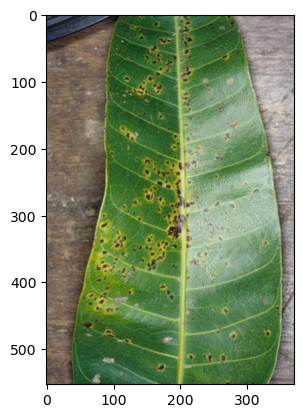

In [60]:
img=plt.imread('image.png')
plt.imshow(img.astype("float"))

Visualizing random images

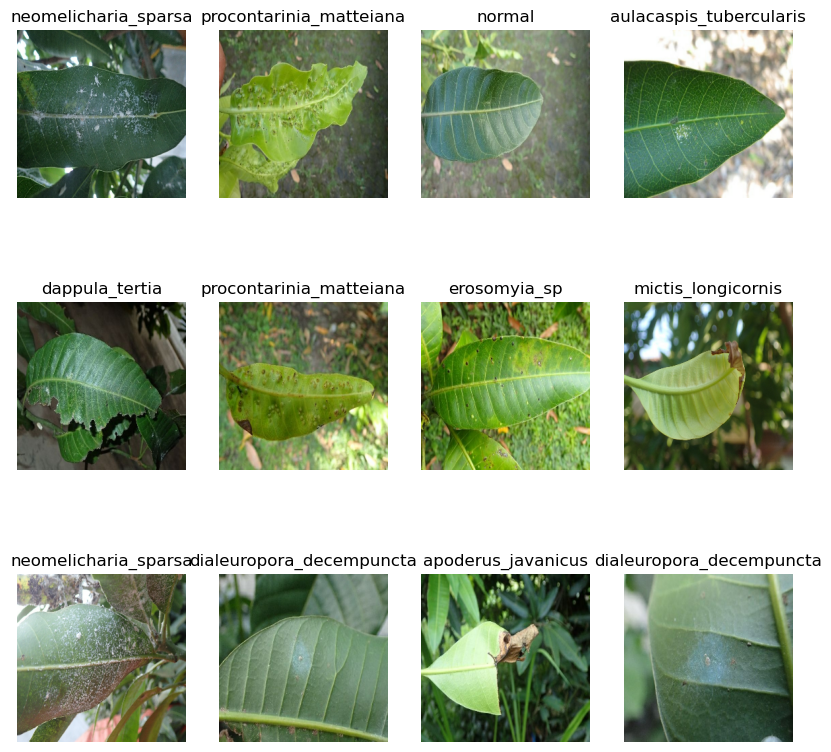

In [13]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Splitting dataset into train and test

In [14]:
len(dataset)

10

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

8

In [18]:
len(val_ds)

1

In [19]:
len(test_ds)

1

Cache, Shuffle, and Prefetch the Dataset

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Building the Model

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the architecture using cnn here

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 16

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 150, mode = 'auto', restore_best_weights = True, verbose = 1)
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=150, callbacks=callback
)

Epoch 1/150
8/8 [==============================] - 10s 1s/step - loss: 0.8142 - accuracy: 0.7227 - val_loss: 1.0002 - val_accuracy: 0.5938
Epoch 2/150
8/8 [==============================] - 8s 1s/step - loss: 0.7378 - accuracy: 0.7383 - val_loss: 0.6778 - val_accuracy: 0.7500
Epoch 3/150
8/8 [==============================] - 8s 998ms/step - loss: 0.7268 - accuracy: 0.7344 - val_loss: 0.9395 - val_accuracy: 0.5938
Epoch 4/150
8/8 [==============================] - 8s 1s/step - loss: 0.8672 - accuracy: 0.7070 - val_loss: 0.8703 - val_accuracy: 0.6562
Epoch 5/150
8/8 [==============================] - 8s 982ms/step - loss: 0.8062 - accuracy: 0.7383 - val_loss: 0.6949 - val_accuracy: 0.7812
Epoch 6/150
8/8 [==============================] - 8s 999ms/step - loss: 0.8597 - accuracy: 0.7188 - val_loss: 0.8414 - val_accuracy: 0.6875
Epoch 7/150
8/8 [==============================] - 8s 975ms/step - loss: 0.7920 - accuracy: 0.7109 - val_loss: 1.0289 - val_accuracy: 0.6250
Epoch 8/150
8/8 [====

Epoch 118/150
8/8 [==============================] - 10s 1s/step - loss: 0.2257 - accuracy: 0.9492 - val_loss: 0.4018 - val_accuracy: 0.9062
Epoch 119/150
8/8 [==============================] - 9s 1s/step - loss: 0.1950 - accuracy: 0.9375 - val_loss: 0.4021 - val_accuracy: 0.8750
Epoch 120/150
8/8 [==============================] - 9s 1s/step - loss: 0.2254 - accuracy: 0.9375 - val_loss: 0.7975 - val_accuracy: 0.8438
Epoch 121/150
8/8 [==============================] - 9s 1s/step - loss: 0.2399 - accuracy: 0.9023 - val_loss: 0.2219 - val_accuracy: 0.9062
Epoch 122/150
8/8 [==============================] - 8s 1s/step - loss: 0.1736 - accuracy: 0.9453 - val_loss: 0.3772 - val_accuracy: 0.9062
Epoch 123/150
8/8 [==============================] - 9s 1s/step - loss: 0.1898 - accuracy: 0.9258 - val_loss: 0.3936 - val_accuracy: 0.9062
Epoch 124/150
8/8 [==============================] - 9s 1s/step - loss: 0.2399 - accuracy: 0.9414 - val_loss: 0.4883 - val_accuracy: 0.8438
Epoch 125/150
8/8 [

In [32]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 1s 885ms/step - loss: 0.0718 - accuracy: 1.0000


Plotting the Accuracy and Loss Curves

In [1]:
history.params

NameError: name 'history' is not defined

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

150

In [37]:
history.history['loss'][:5]

[0.8141945004463196,
 0.7378365993499756,
 0.7267685532569885,
 0.8671969771385193,
 0.8061665296554565]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

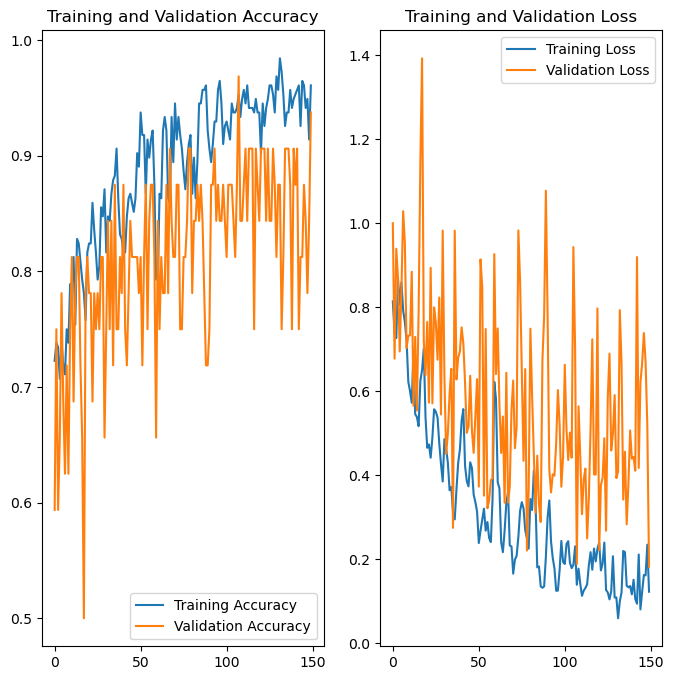

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(150), acc, label='Training Accuracy')
plt.plot(range(150), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(150), loss, label='Training Loss')
plt.plot(range(150), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: normal
1/1 [==============================] - 0s 208ms/step
predicted label: normal


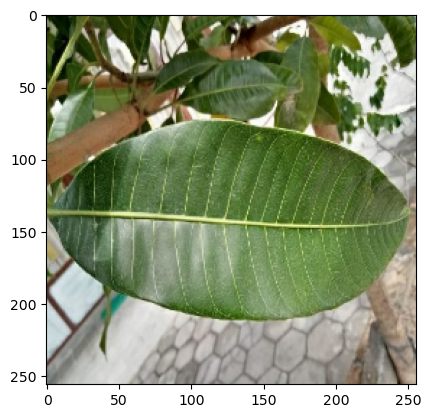

In [46]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[9].numpy().astype('uint8')
    first_label = labels_batch[9].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[9])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

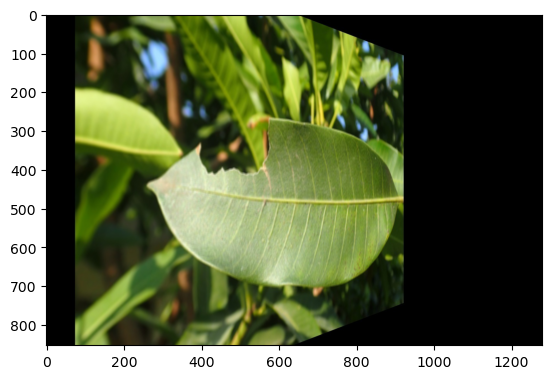

In [73]:
img=plt.imread('Image_6.jpg')
plt.imshow(img.astype("uint8"))

1/1 [==============================] - 0s 50ms/step
valanga_nigricornis
99.25


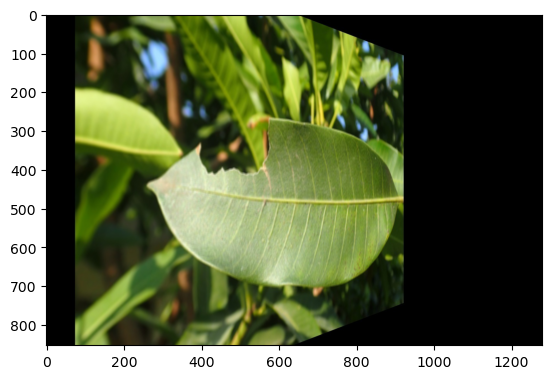

In [75]:
plt.imshow(img.astype("uint8"))
predicted_class, confidence = predict(model, img)
print(predicted_class)
print(confidence)

1/1 [==============================] - 0s 31ms/step


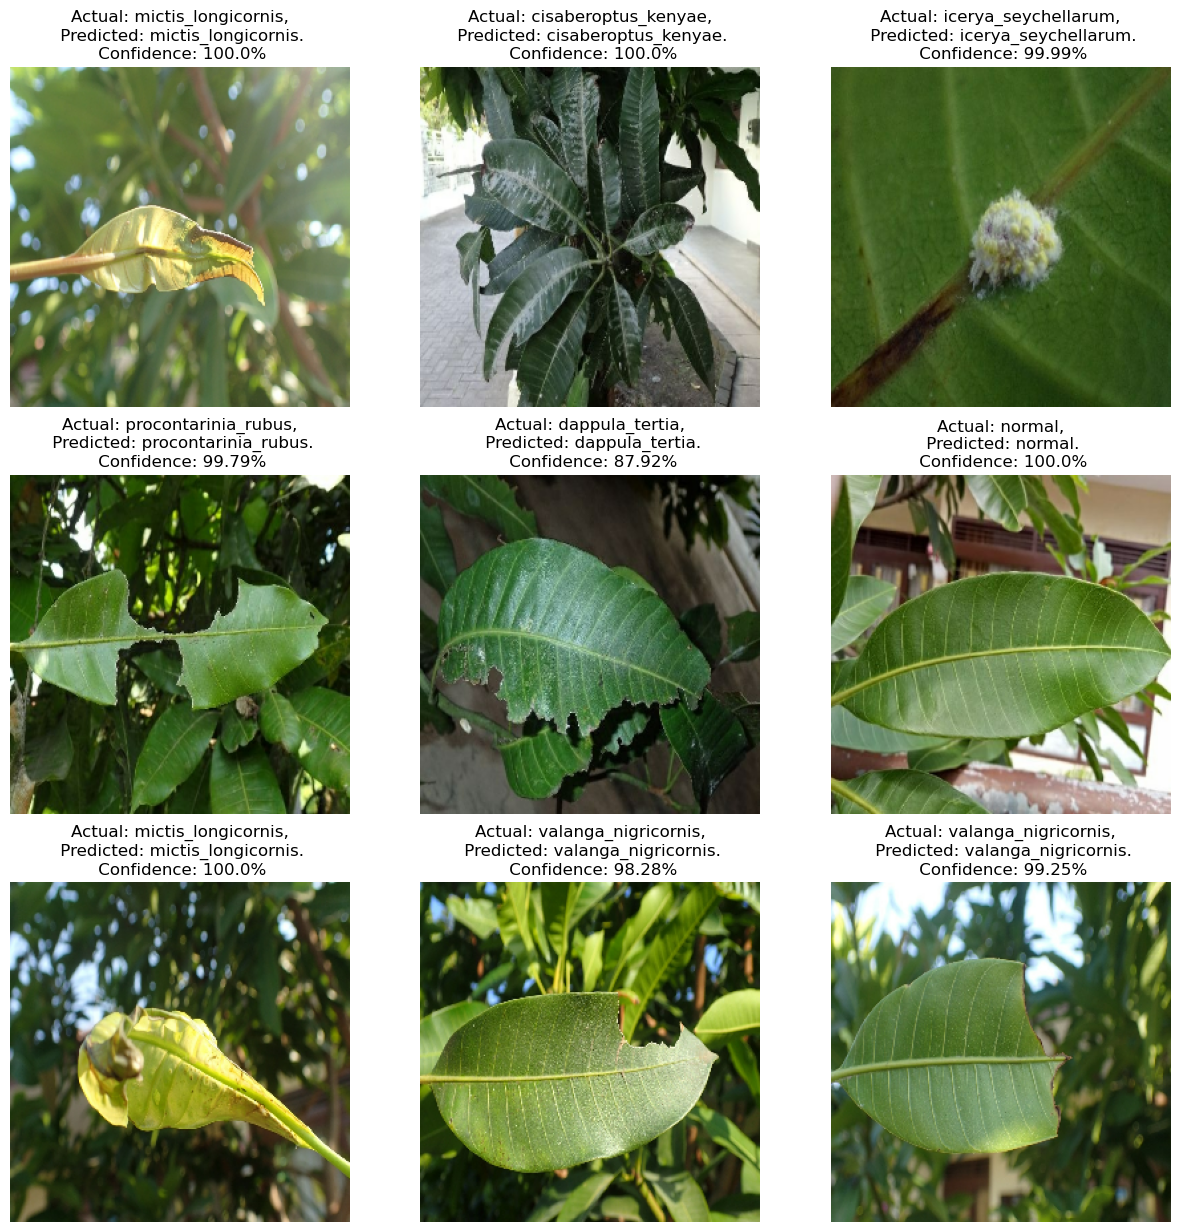

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the model

In [43]:
tf.keras.models.save_model(model,'my_model.hdf5')

C:\Users\Namrata\AppData\Local\Temp\ipykernel_12924\1701436818.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'my_model.hdf5')
